# Velofahren in der Stadt durch die Linse der Zeitreihenanalyse - Zeitreihenanalyse

Detaillierte Informationen zu den Zähldaten von Velofahrten bei der Unterführung Langstrasse an der Ecke Langstrasse - Europaallee (Zürich) sind im Notebook [01-Datenaufbereitung](https://github.com/curdon/velo-prophet/blob/main/Datenanalyse/Code/01-Datenaufbereitung.ipynb) zusammengefasst.

In diesem Notebook werden die aufbereiteten Zähldaten gelesen und mit der Software [Prophet](https://facebook.github.io/prophet/) analysiert. Im Speziellen wird die Zeitreihe in Komponenten wie Trend und Saisonalität aufgeteilt. Prophet erwartet eine Input-Datei mit zwei Spalten, *ds* (Zeitstempel) und *y* (Messwert).

## Python Bibliotheken laden

In [3]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

## Aufbereitete Velozähldaten laden

In [21]:
velo_messungen = pd.read_csv("../Daten/velozaehldaten_aufbereitet.csv", index_col=0)

In [22]:
velo_messungen['ds'] = pd.to_datetime(velo_messungen['ds'], format="%Y-%m-%dT%H:%M")

In [23]:
velo_messungen.head(10)

,ds,y
0,2021-01-01 00:00:00,22.0
1,2021-01-01 01:00:00,53.0
2,2021-01-01 02:00:00,73.0
3,2021-01-01 03:00:00,53.0
4,2021-01-01 04:00:00,36.0
5,2021-01-01 05:00:00,20.0
6,2021-01-01 06:00:00,23.0
7,2021-01-01 07:00:00,17.0
8,2021-01-01 08:00:00,10.0
9,2021-01-01 09:00:00,20.0


## Prophet Model erstellen und konfigurieren

- Wir erstellen ein Prophet Model, welches keine Changepoints hat (*n_changepoints=0*). Das bedeutet, dass sich der Trend über den Beobachtungszeitraum nicht ändert (bzw. konstant zu- oder abnimmt). Dies vereinfacht die Interpretation der Resultate, entspricht aber nicht unbedingt dem besten Zeitreihenmodel. Wenn nichts angegeben wird, wird die Anzahl Changepoints von Prophet geschätzt.
- Mit der Funktion *add_country_holidays(country_name='CH')* können wir automatisch die offiziellen Feiertage der Schweiz hinzufügen. Die Annahme ist, dass die Anzahl Velofahrten während der Feiertage von einem normalen Tag abweicht.

In [15]:
velo_model = Prophet(n_changepoints=0)
velo_model.add_country_holidays(country_name='CH')

## Prophet Model berechnen und auf die Daten anwenden

In [ ]:
velo_model.fit(velo_messungen)
velo_vorhersage = velo_model.predict(velo_messungen)

## Zeitreihen-Komponenten darstellen

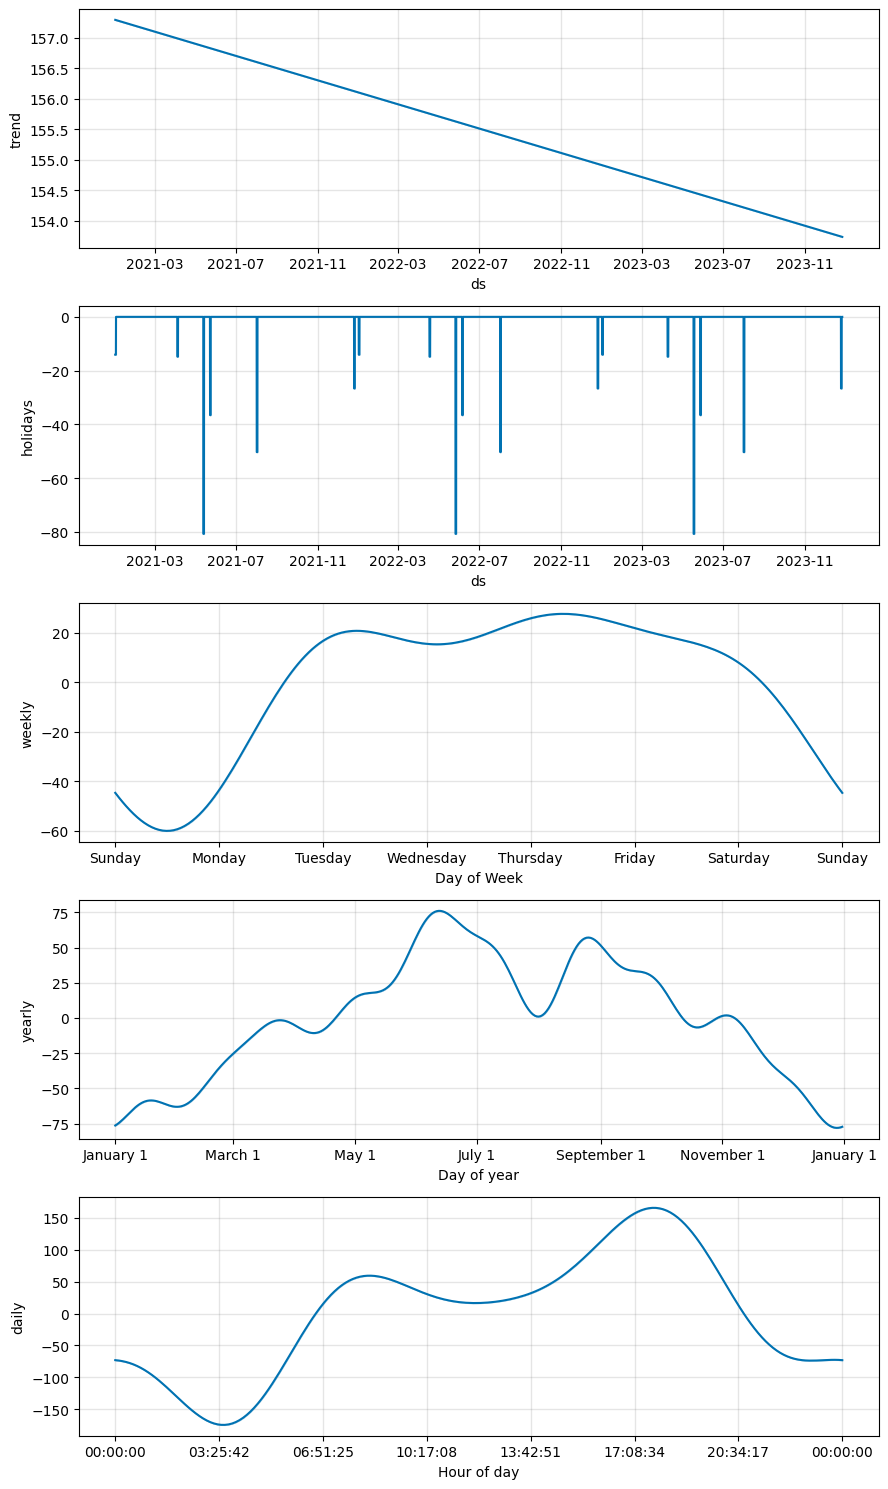

In [37]:
fig_komponenten = velo_model.plot_components(velo_vorhersage)

### Lesehilfe zu der Komponenten-Abbildung

- Jede wichtige Komponente der Zeitreihe wird als eigene Graphik dargestellt. In unserem Fall werden die Velozählungen in einen Trend, Feiertage und Saisonalitäten für Jahre, Wochen und Tage unterteilt.
- Trend: Die Velofahrten nehmen über die drei Jahre leicht ab (von 157 auf 154 Zählungen pro Stunde)
- Feiertage (*holidays*): Die vertikalen Striche zeigen an, wie stark sich die Anzahl Velofahrten an einem Feiertag von einem normalen Tag unterscheiden. Alle Feiertage haben einen negativen Effekt auf die Anzahl Velofahrten. An der Auffahrt weichen die Zähldaten am stärksten von den Erwartungen ab. Es werden ca. 80 Fahrten pro Stunde weniger gezählt. Spezielle Feiertage für Zürich, wie Sechseläuten oder 1. Mai könnten noch zusätzlich erfasst werden.
- Jahreszeitliche Schwankungen (*yearly*): Grundsätzlich werden im Sommer mehr Velofahrten gezählt als im Winter. Mitten im Sommer, während der Sommerferien, gibt es jedoch einen Einbruch in den Zähldaten.
- Wöchentliche Schwankungen (*weekly*): Am Sonntag benützen am wenigsten Züricher das Velo. Die meisten Velofahrten werden am Donnerstag gezählt.
- Tägliche Schwankungen (*daily*): An einem durchschnittlichen Tag gibt es zwei Maximas an Velozählungen. Diese repräsentieren die Pendlerbewegungen am Morgen hin zum Arbeitsplatz (ca. 07:30:00) und am Abend zurück nach Hause (ca. 17:30:00).

## Vergleich Vorhersagen und Zählwerte

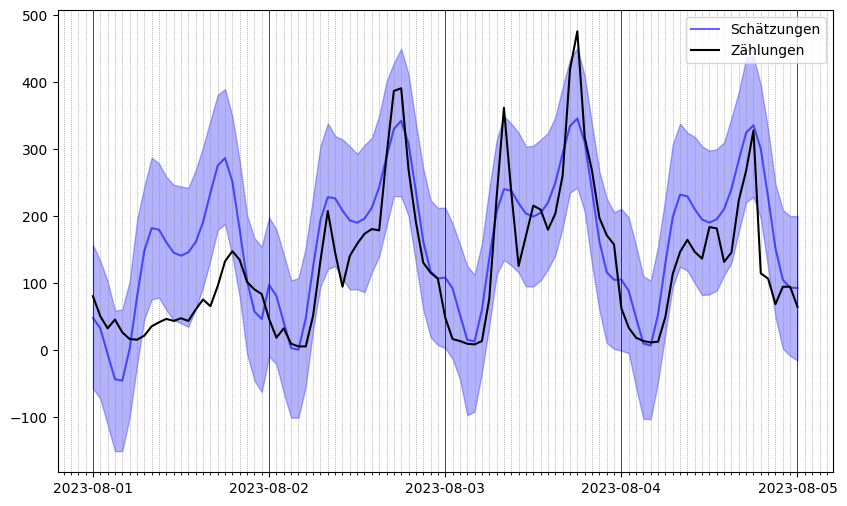

In [29]:
# Filtering data for plotting
start = datetime(2023, 8, 1)
end = datetime(2023, 8, 5)
forecast_filtered = velo_vorhersage[(velo_vorhersage['ds'] >= start) & (velo_vorhersage['ds'] <= end)]
actual_filtered = velo_messungen[(velo_messungen['ds'] >= start) & (velo_messungen['ds'] <= end)]

# Plotting predictions
plt.figure(figsize=(10, 6))
plt.plot(forecast_filtered['ds'], forecast_filtered['yhat'], color='blue', alpha=0.6, label='Schätzungen')
plt.fill_between(forecast_filtered['ds'], forecast_filtered['yhat_lower'], forecast_filtered['yhat_upper'], color='blue', alpha=0.3)
plt.plot(actual_filtered['ds'], actual_filtered['y'], label='Zählungen', color = "black")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.legend()

# Setting major and minor gridlines
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Enable grid only for x-axis
ax.xaxis.grid(True, which='major', linestyle='-', linewidth='0.5', color='black')  # Major gridlines for x-axis
ax.xaxis.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')  # Minor gridlines for x-axis


plt.show()

## Residuen darstellen

Residuen sind der Unterschied zwischen einem beobachteten Zählwert zu einem Zeitpunkt und dem Vorhersagewert

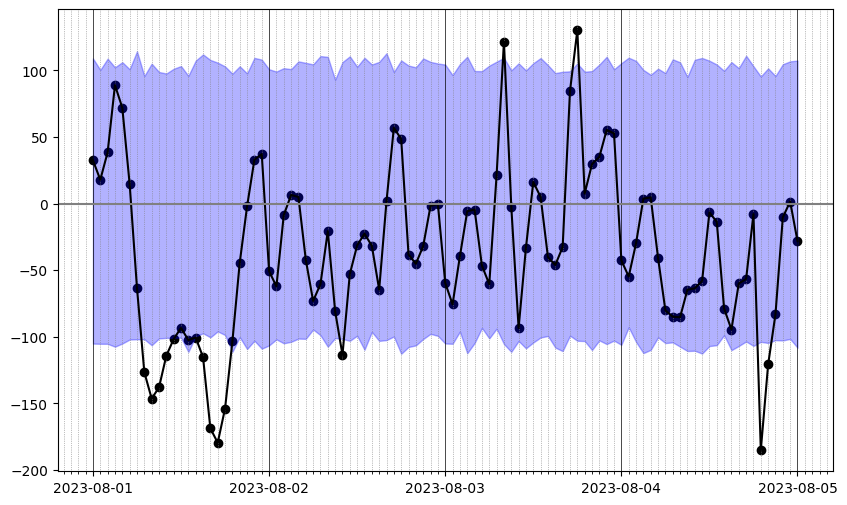

In [35]:
# Calculating residuals
residuals = pd.DataFrame({
    'residuals': actual_filtered['y'] - forecast_filtered['yhat'],
    'ds': actual_filtered['ds'],
    'lower': forecast_filtered['yhat_lower'] - forecast_filtered['yhat'],
    'upper': forecast_filtered['yhat_upper'] - forecast_filtered['yhat']
})

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals['ds'], residuals['residuals'], color = "black")
plt.scatter(residuals['ds'], residuals['residuals'], color = "black")
plt.fill_between(residuals['ds'], residuals['lower'], residuals['upper'], color='blue', alpha=0.3)
plt.axhline(y=0, color='grey')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())

# Setting major and minor gridlines
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Enable grid only for x-axis
ax.xaxis.grid(True, which='major', linestyle='-', linewidth='0.5', color='black')  # Major gridlines for x-axis
ax.xaxis.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')  # Minor gridlines for x-axis

plt.show()